<a href="https://colab.research.google.com/github/sarthikac/Hybrid-CNN-LSTM-Model3-9/blob/main/4layerCNN73pctacc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
def do_import():
  global np,pd,keras,Sequential,Dense, Activation, Flatten,Dropout,Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape,to_categorical,plt,os
  import os
  import numpy as np
  import pandas as pd
  import keras
  from keras.models import Sequential
  from keras.layers import Dense, Activation, Flatten,Dropout
  from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
  from keras.utils import to_categorical
  import matplotlib.pyplot as plt
## Loading and visualizing the data

## Loading the dataset
def load_data():
  global x_test, y_test, X_train_valid, y_train_valid, X_test, person_train_valid, person_test

  X_test = np.load("X_test.npy")
  y_test = np.load("y_test.npy")
  person_train_valid = np.load("person_train_valid.npy")
  X_train_valid = np.load("X_train_valid.npy")
  print(X_train_valid.shape)
  y_train_valid = np.load("y_train_valid.npy")
  person_test = np.load("person_test.npy")

  ## Adjusting the labels so that

  # Cue onset left - 0
  # Cue onset right - 1
  # Cue onset foot - 2
  # Cue onset tongue - 3

  y_train_valid -= 769
  y_test -= 769

  ## Visualizing the data

  ch_data = X_train_valid[:,8,:]


  class_0_ind = np.where(y_train_valid == 0)
  ch_data_class_0 = ch_data[class_0_ind]
  avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


  class_1_ind = np.where(y_train_valid == 1)
  ch_data_class_1 = ch_data[class_1_ind]
  avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

  class_2_ind = np.where(y_train_valid == 2)
  ch_data_class_2 = ch_data[class_2_ind]
  avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

  class_3_ind = np.where(y_train_valid == 3)
  ch_data_class_3 = ch_data[class_3_ind]
  avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


  plt.plot(np.arange(1000),avg_ch_data_class_0)
  plt.plot(np.arange(1000),avg_ch_data_class_1)
  plt.plot(np.arange(1000),avg_ch_data_class_2)
  plt.plot(np.arange(1000),avg_ch_data_class_3)
  plt.axvline(x=500, label='line at t=500',c='cyan')

  plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

def print_shapes():
  print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
  print ('Test data shape: {}'.format(X_test.shape))
  print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
  print ('Test target shape: {}'.format(y_test.shape))
  print ('Person train/valid shape: {}'.format(person_train_valid.shape))
  print ('Person test shape: {}'.format(person_test.shape))

def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    #X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    #Subsampling

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X, sub_sample):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,800)
    #X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

def data_prep():
  global x_test, y_test, X_train_valid, y_train_valid, X_test, person_train_valid, person_test, x_train, y_train,x_valid,y_valid
  ind_valid = np.random.choice(2115, 200, replace=False)
  ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

  (x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
  (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
  print('Shape of training set:',x_train.shape)
  print('Shape of validation set:',x_valid.shape)
  print('Shape of training labels:',y_train.shape)
  print('Shape of validation labels:',y_valid.shape)

  x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
  x_valid = test_data_prep(x_valid, 2)
  X_test_prep = test_data_prep(X_test, 2)

  # Converting the labels to categorical variables for multiclass classification
  y_train = to_categorical(y_train, 4)
  y_valid = to_categorical(y_valid, 4)
  y_test = to_categorical(y_test, 4)
  print('Shape of training labels after categorical conversion:',y_train.shape)
  print('Shape of validation labels after categorical conversion:',y_valid.shape)
  print('Shape of test labels after categorical conversion:',y_test.shape)

  # Adding width of the segment to be 1
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
  x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
  print('Shape of training set after adding width info:',x_train.shape)
  print('Shape of validation set after adding width info:',x_valid.shape)
  print('Shape of test set after adding width info:',x_test.shape)


  # Reshaping the training and validation dataset
  x_train = np.swapaxes(x_train, 1,3)
  x_train = np.swapaxes(x_train, 1,2)
  x_valid = np.swapaxes(x_valid, 1,3)
  x_valid = np.swapaxes(x_valid, 1,2)
  x_test = np.swapaxes(x_test, 1,3)
  x_test = np.swapaxes(x_test, 1,2)
  print('Shape of training set after dimension reshaping:',x_train.shape)
  print('Shape of validation set after dimension reshaping:',x_valid.shape)
  print('Shape of test set after dimension reshaping:',x_test.shape)

def data_prep_original():
  global x_test, y_test, X_train_valid, y_train_valid, X_test, person_train_valid, person_test, x_train, y_train,x_valid,y_valid
  ## Preprocessing the dataset

  X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
  X_test_prep = test_data_prep(X_test, 2)
  ## Random splitting and reshaping the data

  # First generating the training and validation indices using random splitting
  ind_valid = np.random.choice(8460, 800, replace=False)
  ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

  # Creating the training and validation sets using the generated indices
  (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
  (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
  print('Shape of training set:',x_train.shape)
  print('Shape of validation set:',x_valid.shape)
  print('Shape of training labels:',y_train.shape)
  print('Shape of validation labels:',y_valid.shape)


  # Converting the labels to categorical variables for multiclass classification
  y_train = to_categorical(y_train, 4)
  y_valid = to_categorical(y_valid, 4)
  y_test = to_categorical(y_test, 4)
  print('Shape of training labels after categorical conversion:',y_train.shape)
  print('Shape of validation labels after categorical conversion:',y_valid.shape)
  print('Shape of test labels after categorical conversion:',y_test.shape)

  # Adding width of the segment to be 1
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
  x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
  print('Shape of training set after adding width info:',x_train.shape)
  print('Shape of validation set after adding width info:',x_valid.shape)
  print('Shape of test set after adding width info:',x_test.shape)


  # Reshaping the training and validation dataset
  x_train = np.swapaxes(x_train, 1,3)
  x_train = np.swapaxes(x_train, 1,2)
  x_valid = np.swapaxes(x_valid, 1,3)
  x_valid = np.swapaxes(x_valid, 1,2)
  x_test = np.swapaxes(x_test, 1,3)
  x_test = np.swapaxes(x_test, 1,2)
  print('Shape of training set after dimension reshaping:',x_train.shape)
  print('Shape of validation set after dimension reshaping:',x_valid.shape)
  print('Shape of test set after dimension reshaping:',x_test.shape)


def build_cnn():
  global model, kernel_size, activation
  # Building the CNN model using sequential class
  model = Sequential()

  # Conv. block 1
  model.add(Conv2D(filters=25, kernel_size = kernel_size, padding='same', activation=activation, input_shape=(500,1,22)))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Conv. block 2
  model.add(Conv2D(filters=50, kernel_size = kernel_size, padding='same', activation=activation))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Conv. block 3
  model.add(Conv2D(filters=100, kernel_size=kernel_size, padding='same', activation=activation))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Conv. block 4
  model.add(Conv2D(filters=200, kernel_size=kernel_size, padding='same', activation=activation))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  # Output layer with Softmax activation
  model.add(Flatten()) # Flattens the input
  model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


  # Printing the model summary
  model.summary()

def build_hybrid_cnn_lstm():
  global model, kernel_size, activation
  # Building the CNN model using sequential class
  model = Sequential()

  # Conv. block 1
  model.add(Conv2D(filters=25, kernel_size=kernel_size, padding='same', activation=activation, input_shape=(500,1,22)))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  model.add(BatchNormalization())
  model.add(Dropout(0.6))

  #Conv. block 2
  model.add(Conv2D(filters=50, kernel_size=kernel_size, padding='same', activation=activation))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))

  # Conv. block 3
  model.add(Conv2D(filters=100, kernel_size=kernel_size, padding='same', activation=activation))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))

  # Conv. block 4
  model.add(Conv2D(filters=200, kernel_size=kernel_size, padding='same', activation=activation))
  model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.6))

  # FC+LSTM layers
  model.add(Flatten()) # Adding a flattening operation to the output of CNN block
  model.add(Dense((40))) # FC layer with 100 units
  model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
  model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


  # Output layer with Softmax activation
  model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation
  # Printing the model summary
  model.summary()



def configure_compile_model():
  global model,learning_rate,epochs,loss_fn,optimizer
  if (optimizer=="SGD"):
    model_optimizer = keras.optimizers.SGD(learning_rate = learning_rate)
  elif (optimizer=="Adams"):
    model_optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

  model.compile(loss=loss_fn,
                 optimizer=model_optimizer,
                 metrics=['accuracy'])

def fit_model():
  global x_train,y_train,x_valid,y_valid, model_results,batch_size,epochs
  callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
  model_results = model.fit(x_train,
             y_train,
             batch_size=batch_size,
             epochs=epochs,#callbacks =[callback],
             validation_data=(x_valid, y_valid), verbose=True)

def plot_graph():
  global model_results, arch
  # Plotting accuracy trajectory
  plt.plot(model_results.history['accuracy'])
  plt.plot(model_results.history['val_accuracy'])
  plt.title(f'{arch} Model accuracy trajectory')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # Plotting loss trajectory
  plt.plot(model_results.history['loss'],'o')
  plt.plot(model_results.history['val_loss'],'o')
  plt.title(f'{arch} Model loss trajectory')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def test_model():
  global score,model
  score = model.evaluate(x_test, y_test, verbose=0)
  print(f'Test accuracy of the {arch} Model: {score[1]}')

def mount_drive():
  import os
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  os.chdir('/content/drive/MyDrive/cm147_Project/project')


In [10]:
#params_list=[]

Mounted at /content/drive
(2115, 22, 1000)
Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)
Shape of X after trimming: (2115, 22, 1000)
Shape of X after maxpooling: (2115, 22, 500)
Shape of X after averaging+noise and concatenating: (4230, 22, 500)
Shape of X after subsampling and concatenating: (8460, 22, 500)
Shape of Y: (8460,)
Shape of X after trimming: (443, 22, 1000)
Shape of X after maxpooling: (443, 22, 500)
Shape of training set: (7660, 22, 500)
Shape of validation set: (800, 22, 500)
Shape of training labels: (7660,)
Shape of validation labels: (800,)
Shape of training labels after categorical conversion: (7660, 4)
Shape of validation labels after categorical conversion: (800, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7660, 22, 500, 1)
Shape of validation 

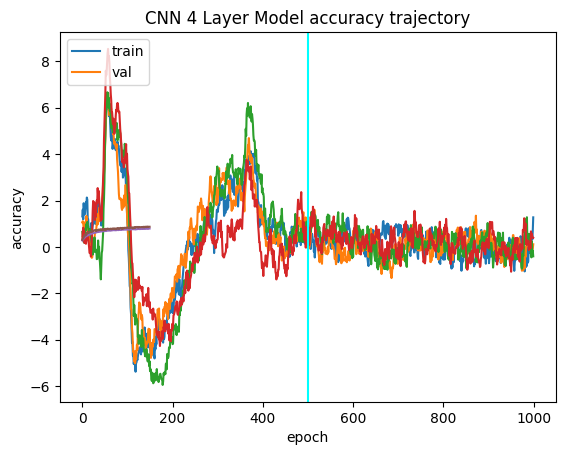

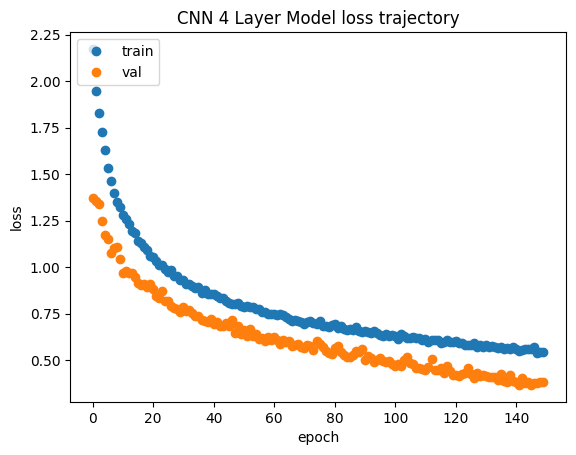

Test accuracy of the CNN 4 Layer Model: 0.7313769459724426
{'Architecture': 'CNN 4 Layer', 'Epochs': 150, 'Batch': 32, 'Optimizer': 'SGD', 'Learning Rate': 0.001, 'Loss Fn': 'categorical_crossentropy', 'Kernel Size': (5, 5), 'Activation Function': 'elu', 'Other': 'Time bins = 1000, Validation Samples= 800, Prep before split valid/train', 'Train Accuracy': 0.7925587296485901, 'Validation Accuracy': 0.8687499761581421, 'Test Accuracy': 0.7313769459724426}
[{'Architecture': 'CNN 4 Layer', 'Epochs': 150, 'Batch': 32, 'Optimizer': 'SGD', 'Learning Rate': 0.001, 'Loss Fn': 'categorical_crossentropy', 'Kernel Size': (5, 5), 'Activation Function': 'elu', 'Other': 'Time bins = 1000, Validation Samples= 800, Prep before split valid/train', 'Train Accuracy': 0.7925587296485901, 'Validation Accuracy': 0.8687499761581421, 'Test Accuracy': 0.7313769459724426}]


In [11]:
global optimizer,learning_rate,epochs,loss_fn,batch_size,model,model_results, arch, kernel_size, activation
optimizer="SGD"   #"Adam"
loss_fn='categorical_crossentropy'
learning_rate = 1e-3
epochs = 150
batch_size=32
kernel_size = (5,5)
activation = 'elu'
arch='CNN 4 Layer'  #'Hybrid CNN LSTM'
other='Time bins = 1000, Validation Samples= 800, Prep before split valid/train'
params={'Architecture':arch,'Epochs':epochs,'Batch':batch_size, 'Optimizer':optimizer, 'Learning Rate':learning_rate,'Loss Fn':loss_fn,
        'Kernel Size': kernel_size, 'Activation Function': activation, 'Other':other}

mount_drive()
do_import()

load_data()
print_shapes()
#data_prep()
data_prep_original()
if arch == 'CNN 4 Layer':
  build_cnn()
elif arch == 'Hybrid CNN LSTM':
  build_hybrid_cnn_lstm()

configure_compile_model()
fit_model()
plot_graph()
test_model()

params['Train Accuracy']=model_results.history['accuracy'][-1]
params['Validation Accuracy']=model_results.history['val_accuracy'][-1]
params['Test Accuracy']=score[1]
print(params)
params_list.append(params)
print(params_list)

In [ ]:
print (model_results.history['accuracy'][-1])

0.6859008073806763
